# This notebook

In this notebook, we exlore which words - other than our keywords - have emerged during the months under analysis as those words that frequenctly occurred in the articles we have pre-filtered as focusing on behavioural science topics.

## Settings

In [1]:
import os

In [2]:
import numpy as np

In [3]:
from math import log2

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import networkx as nx
from operator import itemgetter

In [6]:
%matplotlib inline

In [7]:
from src.news_media.get_keywords_trend import *

/Users/alessiatosi/DS_projects/behavioural-sci-perception/docs/ext/keywords.yaml has been successfully loaded as a dict
/Users/alessiatosi/DS_projects/behavioural-sci-perception/docs/ext/subkw_to_kw_map.yaml has been successfully loaded as a dict


In [8]:
pd.set_option('display.max_colwidth', None)

The config file

In [9]:
CONFIG.keys()

dict_keys(['NgramRange', 'Actors', 'BehavSci', 'Behav_ins', 'Behav_chan', 'Behav_pol', 'Behav_anal', 'Psych', 'Econ_behav', 'Econ_irrational', 'Nudge', 'Nudge_choice', 'Nudge_pater', 'Covid', 'Fatigue', 'Immunity'])

## Import UK's news articles

In [10]:
news_uk = NewsArticles(country="uk")

`news_uk` is a `NewsArticles` class instance, with the following public attributes and methods:

In [11]:
[d for d in dir(news_uk) if not d.startswith("_")]

['allwords_raw_tf',
 'country',
 'data',
 'dates',
 'expand_dict',
 'get_kword_docfreq_week',
 'get_kword_rawfreq_week',
 'get_num_ngrams',
 'kword_docfreq_week',
 'kword_rawfreq',
 'kword_rawfreq_week',
 'kword_reldocfreq_week',
 'kword_relfreq_week',
 'kword_rfrdf_week',
 'kword_yn_occurrence',
 'subkword_raw_tf',
 'unigram_count_perdoc']

`news_uk.data` contains the original dataset of articles:

In [12]:
news_uk.data.shape

(700, 13)

In [13]:
## Extract data needed for analysis

In [14]:
allwords_freqs = news_uk.allwords_raw_tf.copy()

Top 50 most frequent words

In [69]:
allwords_freqs.sum().sort_values(ascending=False)[:50]

people          4229
government      2527
health          1974
coronavirus     1891
virus           1379
time            1206
covid-19        1140
johnson         1041
measures         942
lockdown         922
home             910
sage             866
advice           863
governments      836
week             811
cases            796
group            780
minister         774
number           771
professor        768
pandemic         724
cent             722
risk             719
day              707
ministers        704
uk               692
weeks            670
way              651
care             618
scientists       615
deaths           601
crisis           597
march            597
university       588
distancing       570
country          553
schools          551
days             548
cummings         537
disease          532
restrictions     532
experts          527
data             524
evidence         517
countries        511
world            497
public           485
england      

In [16]:
news_uk.data[['full_text', 'preproc_text']][:1]

,full_text,preproc_text
0,"Dominic Cummings started 2020 with a job ad containing an eccentric set of skills for shaking up government forecasting and decision-making. Is this pure disruption, or do those topics and technologies offer a clue to his plans?The keywords lay a very specific trail of breadcrumbs. Prediction science, cognitive technologies, Cialdini, Pearl's calculus of causation. Agent-based models, storytelling, the Neo4j database his programmers will use. What could this collection of buzzwords mean?I have a pretty good idea, because the expertise Dom wants is a near-perfect description of my work. But I'm unlikely to apply.For a decade I've used exactly this combination of mathematical, economic and computing disciplines to model the economy and the human imagination, giving me a distinctive insight into what Cummings might be up to. I believe he has two ambitious plans - but a critical third step is missing.The first is advanced data science. Finding cause-and-effect levers in huge datasets; approximating when perfect decisions aren't possible. Programming languages, machine learning: essential tools of modern life. Nothing wrong with the civil service getting better at that.The second step is less neutral. Agent-based models are a tool (which I endorse) for running computer simulations of society and testing new policies. Behavioural economics and persuasion technology can sell ideas to a sceptical population: this is what made Cummings famous.But ten years of doing this has taught me a third component is indispensable. It's absent from Silicon Valley's move-fast-break-things philosophy, and from Dom's blog post. The third element is values.For humans, values are our motivation to solve problems and a measure of whether we've succeeded. AI has motivations too. Nudge theory says 'there is no neutral choice architecture', and there is no neutral goal for an algorithm. If you don't give it values, it will inherit them by default.Programmers and economists (I've been both) prefer simple values. The greatest happiness for the greatest number: the perfect algorithmic principle? Until you start to ask: are UK-resident, taxpaying EU nationals included in ""the greatest number"", or only British citizens? If someone needs £30,000 for mobility support or cancer treatment, how is that weighed against the 30 people who'll give up £1,000 to provide it?Until we give values to machines, they can't apply the good judgement that is essential to policy design.Traditional economics seeks the best way for people to get what they want. Dom's ideas will optimise that process. The next step needs cognitive economics: the study of how our brains decide what we want, before we ask how to get it. We are just starting to answer that for humans, let alone AI.To give values to algorithms, we must agree on those values. That means democratic debate, not civil service rules. Only then can we let AI loose on running the country. Policy is not just an optimisation problem, it's a set of choices about the society we want to live in. And until Cummings - and his boss - have shown us what their values are, I'm not ready to help implement them. Leigh Caldwell is a cognitive economist and partner at Irrational Agency Irrational Agency . He blogs at www.knowingandmaking.com www.knowingandmaking.com and tweets at @leighblue.",cummings job ad set skills government forecasting decision-making disruption topics technologies clue plans keywords trail breadcrumbs prediction science technologies cialdini calculus causation models database programmers collection buzzwords idea expertise dom description work decade ive combination disciplines economy imagination insight cummings believe plans step data science levers datasets decisions programming languages machine learning tools life nothing service step models tool computer simulations society policies behavioural_economics persuasion technology ideas population cummings years component absent valleys mov

### Word embeddings and semantic clustering of emerging words 

We will use word embeddings to represent the semantics of these emerging words in vector space and see how they cluster using PCA. To this purpose, we will use BioWordVec, biomedical word embeddings obtained with fastText (https://github.com/ncbi-nlp/BioSentVec).

### 1. Settings

In [17]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

### 2. Load word2vec pretrained embedding

In [18]:
MODELS_LOCATION = os.environ.get("DIR_MODELS")
W2V_MODEL_PATH = os.path.join(MODELS_LOCATION, "BioWordVec_PubMed_MIMICIII_d200.vec.bin")

In [19]:
os.environ.get("DIR_MODELS")

'/Users/alessiatosi/DS_projects/behavioural-sci-perception/docs/ext/models'

In [20]:
try:
    w2v_embeddings = KeyedVectors.load_word2vec_format(W2V_MODEL_PATH, binary=True)
except Exception as e:
    print(e)
print('embeddings successfully loaded')

embeddings successfully loaded


### 3. Retrieve emerging words' vectors

First, let's check whether all the top-50 emerging words have a word2vec representation (this depends on the data on which the word2vec model was trained).

In [21]:
emerging_words = allwords_freqs.sum().sort_values(ascending=False)[:50].index.to_list()

In [22]:
[word for word in emerging_words if not word in w2v_embeddings.vocab]

['covid-19']

Let's recode:
`covid-19` as `coronavirus` (present in the list and in the word2vec model)
`herd_immunity` as `immunity`

In [23]:
emerging_words = ["immunity" if elem=="herd_immunity" else elem for elem in emerging_words]

Retrieve embeddings

In [24]:
words_embeddings = {word: w2v_embeddings[word] for word in emerging_words if word in w2v_embeddings.vocab}

In [25]:
# Take a look at one:
words_embeddings['coronavirus']

array([ 0.36402  ,  0.46335  ,  0.6096   ,  0.87538  , -0.14334  ,
        0.035163 ,  0.30361  , -0.39785  ,  0.93503  ,  0.20384  ,
       -0.07153  ,  1.5519   ,  0.11822  , -0.24652  ,  0.086058 ,
       -0.70525  ,  0.10849  , -0.48865  ,  0.35592  ,  0.50052  ,
        1.0446   , -0.52246  , -1.0474   , -0.59401  , -0.29903  ,
        0.34294  , -0.61624  , -0.49844  ,  0.072756 ,  0.3776   ,
       -0.28515  , -0.67598  , -0.91952  , -0.74865  , -0.23456  ,
        0.46626  ,  1.1255   , -0.42723  , -0.06667  ,  0.39181  ,
       -1.1654   ,  0.25934  , -0.33107  ,  0.28034  ,  0.65391  ,
        0.42485  ,  0.55339  , -0.12891  , -0.36614  ,  0.31501  ,
       -0.78559  ,  0.39892  , -0.61399  ,  0.17491  ,  0.2145   ,
       -0.50554  ,  0.12066  , -0.38944  , -0.39128  ,  0.49954  ,
       -0.54696  , -0.23048  ,  0.47427  ,  0.78073  ,  0.086138 ,
        0.84353  ,  0.18228  ,  0.26829  ,  0.23198  , -0.0076146,
       -0.83728  , -0.16082  , -0.53944  ,  1.1601   , -0.0652

### Cluster emerging words according to their semantic (embeddings) representation

### PCA

We will use PCA (Principal Component Analysis) to visualise the data in a 2-dimensional space and see how the emrging words cluster.

In [26]:
# settings
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [27]:
# fit a 2d PCA model to the vectors
X = w2v_embeddings[[word for word in emerging_words if word in w2v_embeddings.vocab]]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

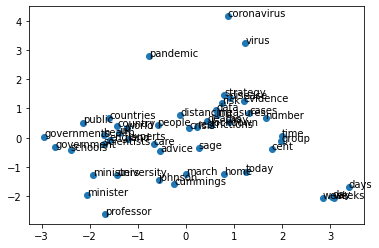

In [28]:
# create a scatter plot of the projection
plt.scatter(result[:, 0], result[:, 1])
words = [word for word in emerging_words if word in w2v_embeddings.vocab]
for i, word in enumerate(words):
	plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

Not easy to see clear groupings for most words with only two dimensions.

### K-means

Let's determines the optimal number of clusters using the elbow method.

This works iteratively by selecting a random coordinate of the cluster center and assign the data points to a cluster. It then calculates the distance of each data point (word embeddings) from the centroid of the closest cluster using either Euclidean or Cosine distance and based on this, it updates the datapoint positions as well as the cluster centers. Within cluster sum of squares (WCSS) is the metric that captured the overall distance of the individual points from the centroid of their closest cluster (the metric that the k-means algorithm is set to minimise). 

The point on the graph where a ‘hinge’ or 'elbow' occurs is considered to be the optimal value of k. 

In [29]:
from sklearn.cluster import KMeans
from nltk.cluster import KMeansClusterer
from nltk.cluster.util import cosine_distance

In [30]:
X = w2v_embeddings[[word for word in emerging_words if word in w2v_embeddings.vocab]]

In [31]:
len(X)

49

In [32]:
len(X[0])

200

Using Euclidean distance

In [58]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=11)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    

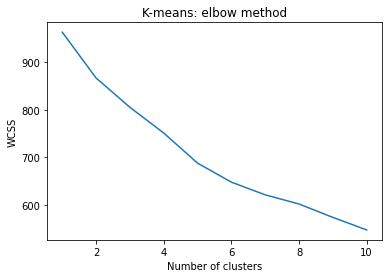

In [59]:
plt.plot(range(1,11), wcss)
plt.title("K-means: elbow method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

Let's calculate the squared of sum distances using cosine distance instead: 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html

In [35]:
from scipy.spatial.distance import cosine, euclidean

In [60]:
wcss = []
for k in range(1,11):
    kclusterer = KMeansClusterer(k, distance=cosine_distance)
    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

    centroids = kclusterer.means()
    
    distances_ = []
    for index_of_word in range(0, X.shape[0]):
        index_of_cluster = assigned_clusters[index_of_word]   # get cluster the word was assigned to
        # squared_distance_from_centroid = (euclidean(X[index_of_word], centroids[index_of_cluster]))**2  # Euclidean distance
        squared_distance_from_centroid = (cosine(X[index_of_word], centroids[index_of_cluster]))**2   # Cosine distance
        distances_.append(squared_distance_from_centroid) 
    print(f"sums for k={k}: {np.sum(distances_)}")
    wcss.append(np.sum(distances_))

sums for k=1: 7.173075023468812
sums for k=2: 5.88889366408849
sums for k=3: 5.063163816220822
sums for k=4: 4.548379288113986
sums for k=5: 4.3881889650404435
sums for k=6: 3.823804934307656
sums for k=7: 3.2436128373384143
sums for k=8: 3.0860357773841685
sums for k=9: 3.1494650338295074
sums for k=10: 2.4965910939811415


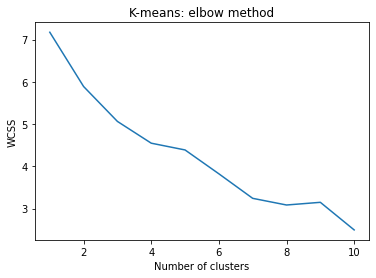

In [61]:
plt.plot(range(1,11), wcss)
plt.title("K-means: elbow method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

Let's follow the distance metric based on cosine similairty and go for 6 clusters.

In [70]:
n_clusters = 6

In [71]:
kclusterer = KMeansClusterer(n_clusters,  distance=cosine_distance, repeats=300)

assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

words = [word for word in emerging_words if word in w2v_embeddings.vocab]

word_clusters = {word: assigned_clusters[i] for i, word in enumerate(words)}

In [72]:
word_clusters_df = pd.Series(word_clusters, name="cluster")

In [73]:
word_clusters_df = word_clusters_df.reset_index()

In [74]:
word_clusters_df.rename(columns={"index": "word"}, inplace=True)

In [75]:
pd.DataFrame(word_clusters_df.groupby("cluster").word.apply(list))

,word
cluster,
0,"[time, home, week, cent, day, weeks, days, today]"
1,"[measures, lockdown, advice, group, ministers, crisis, march, university, distancing, restrictions, strategy]"
2,"[people, government, health, governments, pandemic, uk, care, deaths, country, schools, countries, world, public, england]"
3,"[sage, number, way, scientists, experts, data]"
4,"[johnson, minister, professor, cummings]"
5,"[coronavirus, virus, cases, risk, disease, evidence]"
